# Guide for the P2718 standard

*In the following notebook the guide for P2718 is described.*

## Datasets download

The full dataset Hy_R1.pt has been calculated from row data 'Data_3GHz_Hy_probe10_1cm.txt' obtained by measurements. Hy_R1 can be directly downloaded from here:
https://drive.google.com/file/d/1SUK3FnZ0VlSi_nvsS5eJtJiRx6rxmDFL/view?usp=sharing \
If you want to compute the Hy_R1 from the row data run the 'CF4D_H.py' script by making sure your machine has at least 16GB of RAM.

## Initialization

#### • Libraries initialization

In [1]:
import numpy as np
import torch
from torch import nn
from torch import fft
import scipy.io
from scipy import interpolate
import math
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline #svg format

#### • Parameter initialization

In [3]:
ds=0.015 #sampling rate at every 5mm
fs=1/ds #sampling frequency
D=0.295 #physical distance range
c=3e8 #field propagation velocity
f=3e9 #sampling frequency
lambd=c/f #wavelength
k=2*np.pi/lambd #wave vector

#### • Function to convert .mat into .pt

In [4]:
def mat_to_pt(filename, variablename): #filename and variable must be strings e.g. 'filename.mat' , 'variablename'
    mat = scipy.io.loadmat(filename)
    pt = torch.tensor(mat[variablename],dtype=torch.cfloat)
    return pt

#### • Correlation function

In the section below, the correlation function CF is uploaded. The CF has been obtained considering an extended planar source radiating a stochastic field $\mathbf{F}$ subject to spatial fluctuations. The field has been sampled at two different spatial locations $\mathbf{x_a}=(x_a, y_a)$ and  $\mathbf{x_b}=(x_b, y_b)$ at time $t \in [0 , T]$ in a plane parallel to the source and at a distance $z$. Therefore CF has been obtained as follows:

$$\begin{aligned}
\mathcal{C}_{z}\left(\mathbf{x}_{a}, \mathbf{x}_{b} ; \tau\right) &=\left\langle\mathbf{F}\left(\mathbf{x}_{a}, z ; t+\tau\right) \mathbf{F}\left(\mathbf{x}_{b}, z ; t\right)\right\rangle \\
&=\lim _{T \rightarrow \infty} \frac{1}{2 T} \int_{-T}^{T} \mathbf{F}\left(\mathbf{x}_{a}, z ; t+\tau\right) \mathbf{F}\left(\mathbf{x}_{b}, z ; t\right) \mathrm{d} t
\end{aligned}$$

where $T$ is the total observation time. Then using space–time stochastic magnetic fields yields $\mathbf{F} \equiv \mathbf{H}$ , while starting from the electric field yields $\mathbf{F} \equiv \mathbf{E}$. In a Cartesian frame of reference $\mathbf{F} = [F_x, F_y, F_z]$ the structure in reads:

$$\mathcal{C}_{z}\left(\mathbf{x}_{a}, \mathbf{x}_{b} ; \tau\right)=\left[\begin{array}{ccc}
C_{z}^{x x} & C_{z}^{x y} & C_{z}^{x z} \\
C_{z}^{y x} & C_{z}^{y y} & C_{z}^{y z} \\
C_{z}^{z x} & C_{z}^{z y} & C_{z}^{z z}
\end{array}\right]$$

where the dependence on $\mathbf{x_a}$ and $\mathbf{x_b}$ and on τ in the entries has been omitted for compactness. The final shape of the CF is (60, 60, 60 ,60) tensor. For more details see [[1]](https://ieeexplore.ieee.org/abstract/document/8046114).

#### • CF upolad

In [5]:
Hy_R1=torch.load('Hy_R1.pt')
CF_full=torch.permute(Hy_R1,(0,2,1,3)) #correlation function (CF) is built by permuting the Hy_R1 tensor
del Hy_R1 #Hy_R1 deletion for saving space

#### • CF lite

In order to speed up the run, a liter version of correlation function is calculated. The dimensional reduction is obtained by reducing the resolution from (60,60,60,60) to (20,20,20,20). This data reduction leads to results similar to those related to full correlation function without loss of generality. For more accurate results skip the cell below by making sure your machine has at least 16GB of RAM. Otherwise it is suggested to reduce the amount of data. 

In [6]:
L=20 #number of reduced sample points, from full dimensione L=60 
l=L-1 #L-position
CF=torch.zeros(L,L,L,L, dtype=torch.cfloat)
w=0
for lunghezza in range(0,60,3):
    k=0
    for cubo in range(0,60,3):
        i=0
        for riga in range(0,60,3):
            j=0
            for colonna in range(0,60,3):
                CF[w,k,i,j]=CF_full[lunghezza,cubo,riga,colonna]
                j=j+1
            i=i+1
        k=k+1
    w=w+1
del CF_full

In case you decided to perform the simulation with the full dataset run this cell, otherwise skip it.

In [ ]:
CF=CF_full
del CF_full

## Wigner Function $\mathcal{W}_{z}(\mathbf{x}, \mathbf{p})$

In the frequency domain, this field–field CF is represented by the Fourier transform:

$$\Gamma_{z}\left(\mathbf{x}_{a}, \mathbf{x}_{b} ; \omega\right)=\int_{-\infty}^{\infty} \mathrm{e}^{-i \omega \tau} C_{z}\left(\mathbf{x}_{a}, \mathbf{x}_{b} ; \tau\right) d \tau$$

The Wigner function is defined as follows:

$$\mathcal{W}_{z}(\mathbf{x}, \mathbf{p})=\int \mathrm{e}^{-\mathrm{i} k \mathbf{p} \cdot \mathbf{s}} \Gamma_{z}\left(\mathbf{x}+\frac{\mathbf{s}}{2}, \mathbf{x}-\frac{\mathbf{s}}{2}\right) \mathrm{d} \mathbf{s}$$

where k is the constant wavenumber coordinates ($\mathbf{x}, \mathbf{s}$) related to ($\mathbf{x_a} , \mathbf{x_b}$) by the transformation:

$$\left\{\begin{matrix}\mathbf{x} =\left(\mathbf{x}_{a}+\mathbf{x}_{b}\right) / 2 \\
\mathbf{s} =\mathbf{x}_{a}-\mathbf{x}_{b} \end{matrix}\right.$$

so that $\mathbf{x}$ is the average position and $\mathbf{s}$ is the difference in positions of a pair of measured fields. More explicitly, $\mathbf{s} = (s_x , s_y )$ represents, in the NFS of planar sources, the in-plane displacement (for fixed z) between measurement positions. The conjugate momentum vector $\mathbf{p} = (p_x , p_y )$ takes the geometrical meaning of the components of the wavevector parallel to the source plane. Moreover WF can also be obtained treating position and momentum variables symmetrically as follows:

$$
\mathcal{W}_{z}(\mathbf{x}, \mathbf{p})=\left(\frac{k}{2 \pi}\right)^{2} \int \mathrm{e}^{\mathrm{i} k \mathbf{x} \cdot \mathbf{q}} \tilde{\Gamma}_{z}\left(\mathbf{p}+\frac{\mathbf{q}}{2}, \mathbf{p}-\frac{\mathbf{q}}{2}\right) \mathrm{d} \mathbf{q}
$$
where coordinates $(\mathbf{p}, \mathbf{q})$ are similarly obtained from $\left(\mathbf{p}_{a}, \mathbf{p}_{b}\right)$ through the rotation
$$
\begin{aligned}
&\mathbf{p}=\left(\mathbf{p}_{a}+\mathbf{p}_{b}\right) / 2 \\
&\mathbf{q}=\mathbf{p}_{a}-\mathbf{p}_{b}
\end{aligned}
$$
and the momentum representation of the CF is obtained as follows:

$$\tilde{\Gamma}_{z}\left(\mathbf{p}_{a}, \mathbf{p}_{b}\right)=\iint \mathrm{e}^{-\mathrm{i} k\left(\mathbf{p}_{a} \cdot \mathbf{x}_{a}-\mathbf{p}_{b} \cdot \mathbf{x}_{b}\right)} \Gamma_{z}\left(\mathbf{x}_{a}, \mathbf{x}_{b}\right) \mathrm{d} \mathbf{x}_{a} \mathrm{~d} \mathbf{x}_{b}$$

Starting from these considerations, in the following sections the Wigner function $\mathcal{W}_{z}(\mathbf{x}, \mathbf{p})$ is calculated.
The variable change process has been followed for each spatial locations $x$ (part 1) and $y$ (part 2). For more details see [[1]](https://ieeexplore.ieee.org/abstract/document/8046114).

#### • Variable change - Part 1

In [7]:
Q=torch.zeros(2*L-1,2*L-1, dtype=torch.cfloat) #preallocate Q
AA=torch.zeros(2*L-1,2*L-1,L,L, dtype=torch.cfloat) #preallocate AA

for k in range(0,L):
    for n in range(0,L): 
        R=CF[:,:,k,n] #R(x1,x2)
        
        #Variable rotation for each inner matrix R(X2,X1) -> R(x,sx)
        for X1 in range(1,L+1): #nx matrix
            for X2 in range(1,L+1): #ny matrix
                x=(X1+X2)/2 #change of variable X1, X2 to x
                sx=round(X1-X2) #change of variable X1, X2 to sx
                Q[sx+L-1,(X1+X2)-2]=R[X1-1,X2-1] #Q(sx,x) matrix
        #Averaging in between the values already calculated after variable change
        for h in range(1,2*L-2,2):
            Q[h,l]=(Q[h-1,l]+Q[h,l-1]+Q[h,l+1]+Q[h+1,l])/4 #Q[h,l]
        for t in range(1,L):
            for m in range(1,L):
                Q[m+t-1,L-m+t-1]=(Q[m+t-2,L-m+t-1]+Q[m+t-1,L-m+t-2]+Q[m+t-1,L-m+t]+Q[m+t,L-m+t-1])/4
        
        #After averaging, arrangement of the rotated inner matrix into AA(sx,x,x2,y2)
        AA[:,:,k,n]=Q #AA(sx,x,y2,y1) matrix
        
del CF, R, Q #CF, R, Q deletion

#### • Variable change - Part 2

In [8]:
R=AA #AA matrix duplicate, AA(sx,x,y1,y2)
q=torch.zeros(2*L-1,2*L-1,2*L-1,2*L-1, dtype=torch.cfloat) #preallocate q

#Variable change on the outer correlation matrix R(X1,X2) -> R(x,s)
for y1 in range(1,L+1): #nx matrix
    for y2 in range(1,L+1): #ny matrix
        y=(y1+y2)/2 #change of variable y1, y2 to y
        sy=(y1-y2) #change of variable y1, y2 to sy 
        q[:,:,sy+L-1,(y1+y2)-2]=R[:,:,y1-1,y2-1] #D(s,x) matrix

#Averaging in between the real value after variable change
for h in range(1,2*L-2,2):
    q[:,:,h,l] = (q[:,:,h-1,l]+q[:,:,h,l-1]+q[:,:,h,l+1]+q[:,:,h+1,l])/4
for t in range(1,L):
    for m in range(1,L):
        q[:,:,m+t-1,L-m+t-1] = (q[:,:,m+t-2,L-m+t-1]+q[:,:,m+t-1,L-m+t-2]+q[:,:,m+t-1,L-m+t]+q[:,:,m+t,L-m+t-1])/4

del R, AA #R, AA deletion

#### • Rearrangement of $Q(sx,x,sy,y)$ into $Q(sy,sx,y,x)$ and FFT2 execution on sx and sy 

In [9]:
CFr=torch.permute(q,(2,0,3,1)) #rearrange Q to be CFr(sy,sx,y,x)
del q #q deletion

pmax=lambd/2*fs #pmax
rang = 1.5 #new P range: -1.5 < P < 1.5 
NFFT=round((2*L-1)*(lambd*fs)/(rang*2)) #zero padding value
WF=torch.zeros(2*L-1,2*L-1,2*L-1,2*L-1, dtype=torch.cfloat) #Wigner Function (WF) initialization

for y in range(0,2*L-1):
    print(y, end =" ")
    for x in range(0,2*L-1):
        s=CFr[:,:,y,x]
        padx=(NFFT-(2*L-1))/2 #padding value
        S=torch.tensor(np.pad(s,round(padx)))
        #For range -1.5 to 1.5 with zero padding
        S1=fft.fftshift(fft.fft2((fft.ifftshift(S))))
        WF[:,:,y,x]= S1[math.ceil(-L+(NFFT/2)+1)-1:math.ceil(L+(NFFT/2)-1),math.ceil(-L+(NFFT/2)+1)-1:math.ceil(L+(NFFT/2)-1)] #WF(py,px,y,x)
print('Done!')

del CFr, s, S, S1 #CFr, s, S, S1 deletion

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 Done!


#### • Plot $\mathcal{W}_{z}(\mathbf{x}, \mathbf{p})$

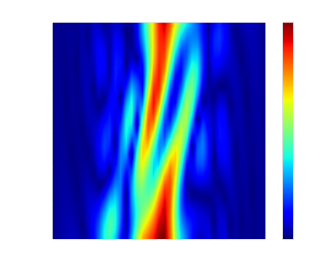

In [23]:
plt.figure()
plt.imshow(torch.squeeze(torch.abs((WF[l,:,l,:]))), cmap='jet', interpolation="bilinear", extent=[-D/2,D/2,-1.5,1.5], aspect = 0.10)
plt.title('WF at 1 cm')
plt.xlabel("$x_1$ [m]")
plt.ylabel("Momentum [$P_x$]")
plt.colorbar()
plt.show()

## Frobenius Perron approximation of $\mathcal{W}_{z}(\mathbf{x}, \mathbf{p})$ (x-domain)

Recasting the source CF obtained from boundary data into a source WF, an exact transport operator is found in integral form, which can be approximated at leading order with a Frobenius-Perron transport equation as follows:

$$\mathcal{W}_{z}(\mathbf{x}, \mathbf{p}) \approx \begin{cases}\mathcal{W}_{0}\left(\mathbf{x}-\frac{z \mathbf{p}}{T(\mathbf{p})}, \mathbf{p}\right) & |\mathbf{p}|<1 \\ \mathcal{W}_{0}(\mathbf{x}, \mathbf{p}) \mathrm{e}^{-2 k z \sqrt{p^{2}-1}} & |\mathbf{p}|>1\end{cases}$$

and where:

$$T(\mathbf{p})= \begin{cases}\sqrt{1-p^{2}} & \text { for } p^{2} \leq 1 \\ i \sqrt{p^{2}-1} & \text { for } p^{2}>1\end{cases}$$

For more details see [[1]](https://ieeexplore.ieee.org/abstract/document/8046114).

#### • Frobenius Perron approximation computation

In [11]:
pmax=lambd/2*fs #pmax
NFFT=2*L-1 #zero padding value
z=0.09 #propagaion distance
n=2*L-1 #resolution
x1, y1 = torch.meshgrid(torch.linspace(-D/2,D/2,n),torch.linspace(-D/2,D/2,n), indexing='xy')
Px=torch.linspace(-1.5,1.5,NFFT)
Py=torch.linspace(-1.5,1.5,NFFT)
mag_p=torch.zeros(NFFT,NFFT)

for ipy in range(0,NFFT):
    for ipx in range(0,NFFT):
        mag_p[ipy,ipx]=torch.sqrt(Px[ipx]**2+Py[ipy]**2) #Mag_p(py,px)
        
Wq1 = torch.zeros(2*L-1,n) #preallocate Wq1
WF2=torch.zeros(2*L-1,2*L-1,2*L-1,2*L-1, dtype=torch.cfloat) #preallocate WF2

for py in range(0, NFFT): #py
    print(py, end =" ")
    for px in range(0,NFFT): #px
        Wx = torch.squeeze(WF[py,px,:,:]) #Wx(y,x) from WF3/WF(py,px,y,x)
        
        #Transform domain
        #Interpolate W with new xq and yq axes
        if torch.abs(mag_p[py,px]) < 1 : #FP propagation
            xq = x1 - z*(Px[px]/torch.sqrt(1-torch.abs(mag_p[py,px])**2))
            yq = y1 - z*(Py[py]/torch.sqrt(1-torch.abs(mag_p[py,px])**2))
            Wq1 = interpolate.griddata((yq.ravel(), xq.ravel()), Wx.ravel(), (y1.ravel(), x1.ravel()), method='cubic', fill_value=0) #1-D data interpolation
            Wq1 = torch.tensor(Wq1).view(2*L-1,2*L-1)
        
        else: #Evanescent propagation
            F = interpolate.griddata((y1.ravel(), x1.ravel()), Wx.ravel(), (y1.ravel(), x1.ravel()), method='cubic', fill_value=0) #1-D data interpolation
            F = torch.tensor(F).view(2*L-1,2*L-1)
            Wq1 = torch.exp(-2*k*z*torch.sqrt(mag_p[py,px]**2-1))* F
        WF2[py,px,:,:] = Wq1 #WF3(py,px,yq,xq)
print('Done!')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 Done!


#### • Plot Frobenius Perron approximation of $\mathcal{W}_{z}(\mathbf{x}, \mathbf{p})$

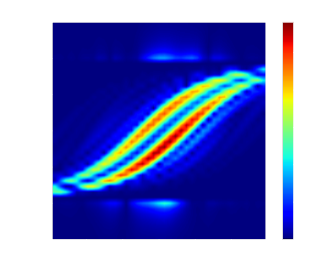

In [24]:
wf2=torch.squeeze(WF2[l+2,:,l+2,:])
plt.figure()
plt.imshow(np.squeeze(np.abs((wf2))),cmap='jet', interpolation="bilinear", extent=[-D/2,D/2,-1.5,1.5], aspect = 0.10)
plt.title('1cm propagated to 15cm')
plt.xlabel("Trasformed Position ($f(X, Z, P)$)")
plt.ylabel("Momentum (P)")
plt.colorbar()
plt.show()

## Inverse $\mathcal{W}_{z}(\mathbf{x}, \mathbf{p})$

#### • Inverse $\mathcal{W}_{z}(\mathbf{x}, \mathbf{p})$ computation

In [13]:
CFr2=torch.zeros(2*L-1,2*L-1,2*L-1,2*L-1, dtype=torch.cfloat) #preallocate CFr2

for y in range(0,2*L-1):
    for x in range(0,2*L-1):
        g=fft.fftshift(fft.ifft2(fft.ifftshift(torch.squeeze(WF2[:,:,y,x]))))
        CFr2[:,:,y,x]=g #CFr2(sy,sx,y,x)
        
CFr3= torch.permute(CFr2,(1,3,0,2)) #CFr3(sx,x,sy,y)

#### • Plot inverse $\mathcal{W}_{z}(\mathbf{x}, \mathbf{p})$

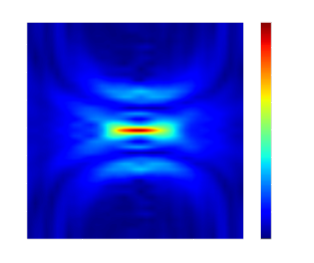

In [25]:
cfr3=torch.squeeze(CFr3[:,:,l,l])
plt.figure()
plt.imshow(torch.abs(torch.squeeze(cfr3)),cmap='jet', interpolation="bilinear", extent=[0,2*L-1,0,2*L-1])
plt.title('CF(sx,x,L,L) - 5cm')
plt.colorbar()
plt.show()

## $H_y$

#### • Change of variable $\mathcal{C}_{z}(:,:,sy,y)$ into $\mathcal{C}_{z}(:,:,y1,y2)$

In [26]:
Cr=torch.zeros(2*L-1,2*L-1,L,L, dtype=torch.cfloat) #preallocate Cr

for y1 in range(1,L+1): #nx matrix 
    for y2 in range(1,L+1): #ny matrix
        y = (y1+y2)/2 #change of variable y1, y2 to y
        sy = (y1-y2) #change of variable y1, y2 to sy
        Cr[:,:,y1-1,y2-1]=CFr3[:,:,sy+L-1,(y1+y2)-2] 

#### • Change of variable $\mathbf{F}(s_x,x)$ into $\mathbf{F}(x_1,x_2)$

In [27]:
RR=torch.zeros(L,L, dtype=torch.cfloat) #preallocate RR
CF2=torch.zeros(L,L,L,L, dtype=torch.cfloat) #preallocate CF2

for k in range (0, L):
    for n in range(0, L):
        F = Cr[:,:,k,n]
        for X1 in range(1, L+1):
            for X2 in range(1, L+1):
                x = (X1+X2)/2 #change of variable X1, X2 to x
                sx = (X1-X2) #change of variable X1, X2 to sx
                RR[X1-1,X2-1] = F[sx+L-1,(X1+X2)-2] #RR(X1,X2)
        CF2[:,:,k,n] = RR #set CF2(x1,x2,y1,y2)

#### • Upload SF1

In [28]:
SF1=torch.load('SF1.pt')
Hy_CF3=CF2*SF1

#### • Plot $H_y$

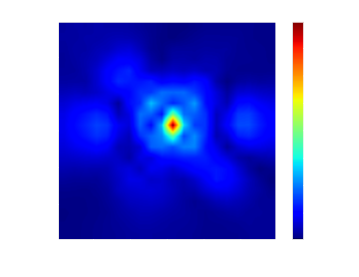

In [29]:
hy_cf3=torch.fliplr(torch.squeeze(Hy_CF3[round(l/2),:,round(l/2),:]))
plt.figure()
plt.imshow(torch.abs(hy_cf3).T,cmap='jet', interpolation="bilinear",extent=[-D/2,D/2,-D/2,D/2])
plt.title('CF propagated to 10 cm')
plt.xlabel("$x_1$ [m]")
plt.ylabel("$y_1$ [m]")
plt.colorbar()
plt.show()

## Bibliography

[1] Gradoni, Gabriele, et al. "Wigner-function-based propagation of stochastic field emissions from planar electromagnetic sources." IEEE Transactions on Electromagnetic Compatibility 60.3 (2017): 580-588.